# Prédictions automatisées

Ce notebook montre comment interagir avec l'API FastAPI du microgrid hospitalier :

1. Vérifier l'état du service (`/health`).
2. Envoyer une requête de prédiction (`/predict`).
3. Calculer une recommandation d'optimisation énergétique (`/optimize`).
4. Optionnel : relancer l'entraînement (`/retrain`).

> Assure-toi d'exécuter `make serve` dans un terminal séparé avant de lancer les cellules.


In [66]:
%pip install requests pyarrow



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
%pip install requests



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [68]:
try:
    import pyarrow as pa
    from pandas.core.arrays.arrow.extension_types import ArrowPyExtensionType

    for ext_name in ["pandas.period", "arrow.py_extension_type"]:
        try:
            pa.unregister_extension_type(ext_name)
        except KeyError:
            pass

    pa.register_extension_type(ArrowPyExtensionType())
except Exception as exc:
    print(f"[WARN] Impossible de gérer le type d'extension Arrow: {exc}")


[WARN] Impossible de gérer le type d'extension Arrow: A type extension with name pandas.period already defined


In [69]:
import os
import datetime as dt
from typing import Any, Dict

import pandas as pd
import requests

BASE_URL = os.environ.get("MICROGRID_API_URL", "http://0.0.0.0:8000")
TIMEOUT = float(os.environ.get("MICROGRID_API_TIMEOUT", 10))


def call_endpoint(method: str, path: str, **kwargs: Any) -> Dict[str, Any]:
    """Helper to call the FastAPI endpoints with basic error handling."""
    url = f"{BASE_URL.rstrip('/')}/{path.lstrip('/')}"
    resp = requests.request(method.upper(), url, timeout=TIMEOUT, **kwargs)
    resp.raise_for_status()
    if resp.headers.get("content-type", "").startswith("application/json"):
        return resp.json()
    return {"raw": resp.text}



In [70]:
health = call_endpoint("GET", "/health")
health


{'status': 'ok', 'model_loaded': True}

In [71]:
data_clean_path = os.environ.get("DATA_CLEAN_DIR", "../data_clean")
merged_path = os.path.join(data_clean_path, "merged.parquet")

history = None
if os.path.exists(merged_path):
    import pyarrow.parquet as pq

    table = pq.read_table(merged_path)
    history = table.to_pandas(ignore_metadata=True).sort_index()
    display(history.tail())
else:
    print("Aucun fichier merged.parquet trouvé. Exécute make prep avant de continuer.")


,temperature_C,irradiance_kWh_m2,pv_prod_kWh,conso_critique_kWh,conso_non_critique_kWh,event,patients,soc_batterie_kWh,total_consumption_kWh,datetime
1455,15.128340,2.394635,2370.688790,5572.800,2167.200,None,1301.0,0.0,7740.0,2024-12-29 18:00:00+00:00
1456,15.894283,0.000000,0.000000,5572.800,2167.200,None,1333.0,0.0,7740.0,2024-12-30 00:00:00+00:00
1457,10.737424,0.294170,291.228546,6018.624,2340.576,None,1337.0,0.0,8359.2,2024-12-30 06:00:00+00:00
1458,11.448284,1.531717,1516.399564,6018.624,2340.576,None,1304.0,0.0,8359.2,2024-12-30 12:00:00+00:00
1459,15.555439,2.581018,2555.208140,5572.800,2167.200,None,1285.0,0.0,7740.0,2024-12-30 18:00:00+00:00


In [72]:
def build_payload(reference: pd.DataFrame) -> Dict[str, Any]:
    """Build a prediction payload using the last known row as baseline."""
    if reference is None or reference.empty:
        raise ValueError("Impossible de construire un payload sans historique.")
    reference = reference.copy()
    if not isinstance(reference.index, pd.DatetimeIndex):
        reference.index = pd.to_datetime(reference.index, utc=True, errors="coerce")
    reference = reference.sort_index()
    last_row = reference.ffill().iloc[-1]
    next_ts = reference.index[-1] + pd.Timedelta(hours=6)
    return {
        "datetime": next_ts.to_pydatetime().isoformat(),
        "temperature_C": float(last_row.get("temperature_C", 25.0)),
        "irradiance_kWh_m2": float(last_row.get("irradiance_kWh_m2", 0.1)),
        "pv_prod_kWh": float(last_row.get("pv_prod_kWh", 100.0)),
        "patients": float(last_row.get("patients", 100.0)),
        "soc_batterie_kWh": float(last_row.get("soc_batterie_kWh", 150.0)),
        "event": "routine",
    }


payload = build_payload(history)
payload


/var/folders/ll/j_17g45j35x08fty79557nfh0000gn/T/ipykernel_53071/1345786425.py:12: UserWarning: Discarding nonzero nanoseconds in conversion.
  "datetime": next_ts.to_pydatetime().isoformat(),


{'datetime': '1970-01-01T06:00:00.000001+00:00',
 'temperature_C': 15.55543891,
 'irradiance_kWh_m2': 2.581018324,
 'pv_prod_kWh': 2555.20814049745,
 'patients': 1285.0,
 'soc_batterie_kWh': 0.0,
 'event': 'routine'}

In [73]:
prediction = call_endpoint("POST", "/predict", json=payload)
prediction


{'pred_kWh': 7875.7666015625,
 'features_used': ['temperature_C',
  'irradiance_kWh_m2',
  'pv_prod_kWh',
  'conso_critique_kWh',
  'conso_non_critique_kWh',
  'patients',
  'soc_batterie_kWh',
  'total_consumption_kWh',
  'event_maintenance',
  'event_missing',
  'event_other_event',
  'event_surconso',
  'hour',
  'dayofweek',
  'is_weekend',
  'month',
  'is_night',
  'lag_6h',
  'lag_12h',
  'lag_24h',
  'roll_mean_24h',
  'roll_std_24h']}

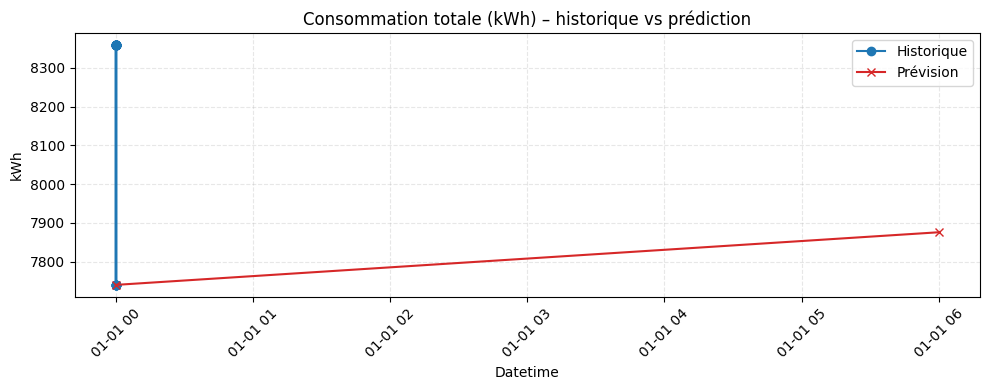

In [74]:
import matplotlib.pyplot as plt

history_window = history["total_consumption_kWh"].astype(float).tail(30)
if not isinstance(history_window.index, pd.DatetimeIndex):
    history_window.index = pd.to_datetime(history_window.index, utc=True, errors="coerce")
future_timestamp = history_window.index[-1] + pd.Timedelta(hours=6)
plot_series = pd.concat(
    [history_window, pd.Series({future_timestamp: float(prediction["pred_kWh"])})]
)

plt.figure(figsize=(10, 4))
plt.plot(plot_series.index[:-1], plot_series.values[:-1], label="Historique", marker="o")
plt.plot(plot_series.index[-2:], plot_series.values[-2:], label="Prévision", marker="x", color="tab:red")
plt.title("Consommation totale (kWh) – historique vs prédiction")
plt.xlabel("Datetime")
plt.ylabel("kWh")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [75]:
opt_payload = {
    "pred_kWh": prediction["pred_kWh"],
    "pv_kWh": payload["pv_prod_kWh"],
    "soc_kwh": payload["soc_batterie_kWh"],
}
opt_result = call_endpoint("POST", "/optimize", json=opt_payload)
opt_result


{'grid_import_kWh': 5320.558461065049,
 'battery_charge_kWh': 0.0,
 'battery_discharge_kWh': 0.0,
 'soc_next': 75.0,
 'note': 'Battery preserved due to SOC limits.'}

In [76]:
# relancer l'entraînement uniquement si nécessaire :
# retrain_result = call_endpoint("POST", "/retrain")
# retrain_result


## Notes

- Mets à jour `payload` pour explorer plusieurs scénarios (météo, PV, patients, événement).
- Pour un lot de prévisions, tu peux boucler sur des timestamps et stocker les résultats dans un `DataFrame`.
- `call_endpoint("GET", "/metrics")` renvoie les performances du modèle courant.
- L’API tourne par défaut sur `http://0.0.0.0:8000` (modifie `BASE_URL` si tu utilises une autre adresse ou un tunnel).
- Le notebook suppose que les dossiers sont accessibles via les variables d'environnement définies dans `.env` (charge-les avec `python-dotenv` si besoin).
